# Person Segmentation

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

import numpy as np
from PIL import Image, ImageOps

In [2]:
tf.config.list_physical_devices('GPU')

[]

* read data into X(original images) and y(segmented images)
* resize to largest image found (all share the same aspect reation)
* convert y to grayscale
* return numpy arrays

In [3]:
size = 320, 180

In [4]:
def get_data(data_dir):
    file_names = np.array(os.listdir(data_dir)[:100])

    X_file_names = file_names[1::4]
    y_file_names = file_names[3::4]

    X = []
    y = []

    for X_file_name, y_file_name in zip(X_file_names, y_file_names):

        X_image = Image.open(os.path.join(data_dir, X_file_name))
        X_image_resized = X_image.resize(size, Image.ANTIALIAS)
        X.append(np.array(X_image_resized))
        y_image = Image.open(os.path.join(data_dir, y_file_name))
        y_image_resized = y_image.resize(size, Image.ANTIALIAS)
        y_image_resized_grayscale = ImageOps.grayscale(y_image_resized)
        y.append(np.array(y_image_resized_grayscale))

    return np.array(X), np.array(y)

In [5]:
DATA_DIR = "../data/projectB_data/images/"
X, y = get_data(DATA_DIR)
print(X.shape)
print(y.shape)



(25, 720, 1280, 3)
(25, 720, 1280)


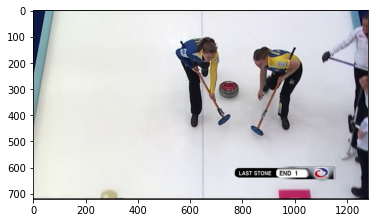

In [6]:
plt.imshow(X[0])

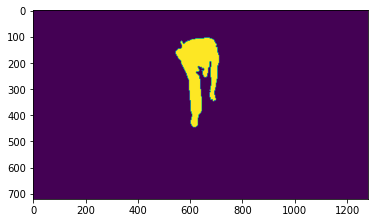

In [7]:
plt.imshow(y[0])

In [8]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c


In [9]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((size[1], size[0], 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [10]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 720, 1280, 3 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 720, 1280, 16 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 720, 1280, 16 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 360, 640, 16) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [11]:
model.fit(X[:80], y[:80], epochs=5, batch_size=10)

Epoch 1/5
